#### Importing some important libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

pd.set_option('display.max_columns', 12, 'display.max_colwidth',\
              3, 'display.expand_frame_repr', False, 'display.max_rows', 200)
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

# plt.rcParams['figure.figsize'] = (8.0, 6.0)
# plt1.rcParams['figure.figsize'] = (15.0, 10.0)

#### Please install latest version of pandas: pip install --upgrade pandas

# About NHANES

The National Health and Nutrition Examination Survey (NHANES) is a program of studies designed to assess the health and nutritional status of adults and children in the United States. The survey is unique in that it combines interviews and physical examinations. NHANES is a major program of the National Center for Health Statistics (NCHS). NCHS is part of the Centers for Disease Control and Prevention (CDC) and has the responsibility for producing vital and health statistics for the Nation.

Ref: https://www.cdc.gov/nchs/nhanes/about_nhanes.htm

The data collected has been divided into 5 components: Demographic, Dietary, Labratory, Questionnare, Examination, and Limited Access Data. Limited Access Data can be accessed after sending a request to Research Data Center. For this task, we will focus on the first 5 categories only except <b>Dietary</b>.

We will merge the datasets downloaded from the above components (Demographic data is definitely required) using a common identifier SEQN which is present in all the datasets. Most NHANES data files contain exactly one record for each sample person who participated in that component (though note that not all sample persons participated in every component.) However, some NHANES data files may contain multiple records for each sample person. For files with this structure, SEQN is not a unique identifier. In such cases, we will first remove columns which have large number of missing values and then perform one-hot encoding to transform the detailed level file (more than 1 row) into a person-level file (with one record for each person) before merging it with demographic and other datafiles.

Ref: https://wwwn.cdc.gov/nchs/nhanes/tutorials/Datasets.aspx

# Process

We will follow the following steps for each dataset:<br>
1. Explanation of each data dictionary<br>
2. Dropping irrelavant columns, if applicable<br>

Finally we will do:

3. Merging <br>
    a. Sorting all the datasets based on SEQN (Ref: https://wwwn.cdc.gov/nchs/nhanes/tutorials/Datasets.aspx (Refer Merge NHANES Data) <br>
    b. Combining all the dataset based on SEQN column<br>
    c. Decoding or renaming the required columns<br>
4. Visualization.

I have chosen only those dataset which consists of only one record for each sample person who participated in that component. 

# Preprocessing

#### Function to drop columns and rows with over 90% of values as null

In [2]:
def filter_columns(df, cutoff=0.9):
    tot_rows = df.shape[0]
    removed_cols = []
    print("original number of columns: ", df.shape[1])
    for col in df.columns:
        num_na = df[col].isna().sum()
        if (num_na/tot_rows) > cutoff:
            #print(col, df[col].isna().sum())
            removed_cols.append(col)
    print("number of columns removed: ", len(removed_cols))
    return df.drop(removed_cols, axis=1)


def filter_rows(df, cutoff=0.9):
    tot_cols = df.shape[1]
    print("original number of rows: ", df.shape[0])
    df = df[df.isnull().sum(axis=1) < tot_cols*cutoff]
    print("remaining rows: ", df.shape[0])
    return df

def trans_cat_cols(df, cat_cols):
    for col in cat_cols:
        df.loc[df[col] != 1, col] = 0
    return df

#### Function to classify age groups

In [3]:
def age_group(age):
    if age <= 19:
        return '0-19'
    elif age <= 29:
        return '20-29'
    elif age <= 39:
        return '30-39'
    elif age <= 49:
        return '40-49'
    elif age <= 59:
        return '50-59'
    else:
        return '60 and above'

#### Function to classify BMI

In [4]:
def categoriseBMI(row):
    if row['BMI'] < 18.5:
        return 'Underweight'
    elif row['BMI'] >= 18.5 and row['BMI'] < 24.9:
        return 'Healthy Weight'
    elif row['BMI'] >= 25 and row['BMI'] < 29.9:
        return 'Over Weight'
    else:
        return 'Obesity'

#### Function to classify HDL Cholesterol

In [5]:
def categoriseHDL(row):
    if row['DirectHDLCholesterolmgdL'] >= 40:
        return 'Normal'
    else:
        return 'Dangerous'

#### Function to classify Healthy Diet

In [6]:
def ClassifyHealthyDiet(row):
    if row['HowHealthyIsYourDiet'] == 1.0:
        return 'Excellent'
    if row['HowHealthyIsYourDiet'] == 2.0:
        return 'Very Good'
    if row['HowHealthyIsYourDiet'] == 3.0:
        return 'Good'
    if row['HowHealthyIsYourDiet'] == 4.0:
        return 'Fair'
    else:
        return 'Poor'

#### Dictionary to decode some of the columns used/required in visualization

In [7]:
decode_columns = {
'RIDAGEYR' : 'Age', # Demographic
'RIAGENDRx': 'Gender', # Demographic
'BMXBMI' : 'BMI', # Body Measures
'BMXHT': 'Standing Height (cm)', # Body Measures
'MCQ160C': 'Coronary_Heart_Disease', # Medical Conditions
'MCQ170L': 'Liver_Condition', # Medical Conditions
'MCQ220': 'Cancer', # Medical Conditions
'DIQ010': 'Diabetes', # Diabetes
'WHD140' : 'Greatest Weight', # Weights
'SMQ856' : 'smoked_at_work', # Smoking - Secondhand Smoke Exposure
'PAQ605' : 'Vigorous_work_activity', # Physical activity
'INDFMPIR': 'family_income', # Demographic
'BPXOSY1': 'SBPReading1', # Blood Pressure - Oscillometric Measurement
'BPXOSY2': 'SBPReading2', # Blood Pressure - Oscillometric Measurement
'BPXOSY3': 'SBPReading3', # Blood Pressure - Oscillometric Measurement
'BPXODI1': 'DBPReading1',# Blood Pressure - Oscillometric Measurement
'BPXODI2': 'DBPReading2',# Blood Pressure - Oscillometric Measurement
'BPXODI3': 'DBPReading3', # Blood Pressure - Oscillometric Measurement
'SMQ020': 'SmokedAtLeast100CigarettesInLife', # Smoking - Cigarette Use
'SMQ040': 'DoYouNowSmokeCigarettes', # Smoking - Cigarette Use
'LBDHDD': 'DirectHDLCholesterolmgdL', # Cholesterol - High - Density Lipoprotein (HDL)
'DBQ700': 'HowHealthyIsYourDiet', # Diet Behavior & Nutrition
'OCQ210': 'Job_Duration', # Occupation
}

#### A. Demographic data (Component: Demographic)

<b>Demographic Data Explanation</b><br>
This demographics file provides information on the following topics:<br>
Survey participant’s household interview and examination status;<br>
Interview and examination sample weights;<br>
Masked variance units;<br>
Language of questionnaires used for the interviews conducted in the household and in the mobile examination center;<br>
Use of proxy or interpreter during the interviews;<br>
The six-month time period when the examination was performed;<br>
Pregnancy status;<br>
The ratio of family income to poverty guidelines; and<br>
Other selected demographic information, such as gender, age, race/Hispanic origin, education, marital status, country of birth, and years of U.S. residence.<br>
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DEMO.htm

In [8]:
Demographic_df = pd.read_sas('P_DEMO.xpt')
Demographic_df = Demographic_df.sort_values(['SEQN'],ascending=[True])
Demographic_df.head(10)

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR      RIDAGEYR  RIDAGEMN  ...  AIALANGA      WTINTPRP      WTMECPRP  SDMVPSU  SDMVSTRA  INDFMPIR
0  109263.0  66.0      2.0       1.0       2.000000e+00 NaN        ... NaN        7891.762435   8.951816e+03  3.0      156.0     4.66    
1  109264.0  66.0      2.0       2.0       1.300000e+01 NaN        ...  1.0       11689.747264  1.227116e+04  1.0      155.0     0.83    
2  109265.0  66.0      2.0       1.0       2.000000e+00 NaN        ... NaN        16273.825939  1.665876e+04  1.0      157.0     3.06    
3  109266.0  66.0      2.0       2.0       2.900000e+01 NaN        ...  1.0       7825.646112   8.154968e+03  2.0      168.0     5.00    
4  109267.0  66.0      1.0       2.0       2.100000e+01 NaN        ... NaN        26379.991724  5.397605e-79  1.0      156.0     5.00    
5  109268.0  66.0      1.0       2.0       1.800000e+01 NaN        ... NaN        19639.221008  5.397605e-79  1.0      155.0     1.66    
6  109269.0  66.0      2.0       1.0       2.000000e+00 NaN        ... NaN        5906.250521   6.848272e+03  2.0      152.0     0.96    
7  109270.0  66.0      2.0       2.0       1.100000e+01 NaN        ... NaN        4613.057696   4.886930e+03  1.0      150.0     1.88    
8  109271.0  66.0      2.0       1.0       4.900000e+01 NaN        ...  1.0       8481.589837   8.658733e+03  1.0      167.0    NaN      
9  109272.0  66.0      2.0       1.0       5.397605e-79  3.0       ... NaN        7037.380216   7.872776e+03  1.0      155.0     0.73    

[10 rows x 29 columns]

In [9]:
# We will drop this column since there is only one unique value.
Demographic_df.drop(['SDDSRVYR'], axis=1, inplace = True)

In [10]:
Demographic_df['RIAGENDRx'] = Demographic_df.RIAGENDR.\
replace({1: 'M', 2: 'F'})
Demographic_df['Marital_Status'] = Demographic_df.\
DMDMARTZ.replace({1: 'Married/With Partner',\
                  2: 'Widowed/Divorced', 3: 'Never_Married',\
                  77: 'None', 99: 'None'})

In [11]:
Demographic_df['RIDAGEYR'] = pd.to_numeric(Demographic_df['RIDAGEYR'],\
                                           errors='coerce')
Demographic_df['Age_Group'] = Demographic_df['RIDAGEYR'].apply(age_group)

In [12]:
Demographic_df.shape

(15560, 31)

#### B. Weight data (Component: Questionnaire)

<b>Weight Data Explanation</b><br>
The Weight History section of the Sample Person Questionnaire (variable name prefix WHQ) provides personal interview data on several topics related to body weight, including self-perception of weight, self-reported weight over the participant’s lifetime, attempted weight loss during the past 12 months, and methods used to try to lose weight and to keep from gaining weight.<br>
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_WHQ.htm

In [13]:
Weight_df = pd.read_sas('P_WHQ.xpt')
Weight_df = Weight_df.sort_values(['SEQN'],ascending=[True])
Weight_df.head(2)

SEQN  WHD010  WHD020  WHQ030  WHQ040  WHD050  ...  WHQ225  WHD110  WHD120  WHD130  WHD140  WHQ150
0  109266.0  64.0    210.0   1.0     2.0     200.0   ...  2.0    NaN      210.0  NaN      218.0   28.0  
1  109267.0  63.0    130.0   3.0     1.0     125.0   ...  5.0    NaN     NaN     NaN      148.0   19.0  

[2 rows x 35 columns]

In [14]:
Weight_df.shape

(10195, 35)

#### C. Medical Conditions (Component: Questionnaire)

<b>Medical Conditions Data Explanation</b><br>
The medical conditions (variable name prefix MCQ) section provides self- and proxy-reported personal interview data on a broad range of health conditions and medical history for both children and adults. The NHANES MCQ section is generally modeled on the “Medical Conditions” questionnaire section of the U.S. National Health Interview Survey.
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_MCQ.htm

In [15]:
MedicalConditions_df = pd.read_sas('P_MCQ.XPT')
MedicalConditions_df = MedicalConditions_df.sort_values(['SEQN'],\
                                                        ascending=[True])
MedicalConditions_df.head(2)

SEQN  MCQ010  MCQ025  MCQ035  MCQ040  MCQ050  ...  MCQ366D  MCQ371A  MCQ371B  MCQ371C  MCQ371D  OSQ230
0  109263.0  2.0    NaN     NaN     NaN     NaN      ... NaN      NaN      NaN      NaN      NaN      NaN    
1  109264.0  2.0    NaN     NaN     NaN     NaN      ... NaN      NaN      NaN      NaN      NaN      NaN    

[2 rows x 63 columns]

In [16]:
MedicalConditions_df.shape

(14986, 63)

#### D. Diabetes (Component: Questionnaire)

<b>Diabetes Data Explanation</b><br>
The 2017-March 2020 pre-pandemic diabetes data file (P_DIQ) provides personal interview data on diabetes, prediabetes, use of insulin or oral hypoglycemic medications, and diabetic retinopathy. It also provides self-reported information on the general knowledge of diabetic complications, and medical or personal cares for the management of diabetes.
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DIQ.htm

In [17]:
Diabetes_df = pd.read_sas('P_DIQ.XPT')
Diabetes_df = Diabetes_df.sort_values(['SEQN'],ascending=[True])
Diabetes_df.head(2)

SEQN  DIQ010  DID040  DIQ160  DIQ180  DIQ050  ...  DID330  DID341  DID350  DIQ350U  DIQ360  DIQ080
0  109263.0  2.0    NaN     NaN     NaN     NaN      ... NaN     NaN     NaN     NaN      NaN     NaN    
1  109264.0  2.0    NaN      2.0     2.0    NaN      ... NaN     NaN     NaN     NaN      NaN     NaN    

[2 rows x 28 columns]

In [18]:
Diabetes_df.shape

(14986, 28)

#### E. Blood Pressure - Oscillometric Measurement (Component: Examination)

<b>Blood Pressure - Oscillometric Measurement Data Explanation</b><br>
This section provides data for three consecutive oscillometric blood pressure (BP) measurements and other methodological measurements to obtain an accurate BP. Pulse is also reported.
Auscultatory BP measurement in NHANES ended after the 2017-2018 survey cycle. Additional details and results from a methodology study, comparing auscultatory and oscillometric BP measurement, are available in an NCHS Vital and Health Statistics Series 2 Report at NCHS website (Ostchega et al, 2021).<br>
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_BPXO.htm

In [19]:
BloodPressure_df = pd.read_sas('P_BPXO.XPT')
BloodPressure_df = BloodPressure_df.sort_values(['SEQN'],ascending=[True])
BloodPressure_df.head(2)

SEQN BPAOARM  BPAOCSZ  BPXOSY1  BPXODI1  BPXOSY2  BPXODI2  BPXOSY3  BPXODI3  BPXOPLS1  BPXOPLS2  BPXOPLS3
0  109264.0  b'R'    3.0      109.0    67.0     109.0    68.0     106.0    66.0     94.0      95.0      91.0    
1  109266.0  b'R'    4.0      99.0     56.0     99.0     55.0     99.0     52.0     68.0      66.0      66.0

In [20]:
#Mean value of the systolic blood preassure measures
BloodPressure_df['Systolic_BP'] = round(((BloodPressure_df.BPXOSY1 +\
                                          BloodPressure_df.BPXOSY2 +\
                                          BloodPressure_df.BPXOSY1)/3), 1)

#Mean value of the diastolic blood preassure measures
BloodPressure_df['Diastolic_BP'] = round(((BloodPressure_df.BPXODI1 +\
                                           BloodPressure_df.BPXODI2 +\
                                           BloodPressure_df.BPXODI2)/3), 1)
#Mean value of the pulse
BloodPressure_df['Pulse'] = round(((BloodPressure_df.BPXOPLS1 +\
                                    BloodPressure_df.BPXOPLS2 +\
                                    BloodPressure_df.BPXOPLS3)/3), 1)

In [21]:
BloodPressure_df.shape

(11656, 15)

#### F. Smoking - Secondhand Smoke Exposure (Component: Questionnaire)

<b>Smoking - Secondhand Smoke Exposure Data Explanation</b><br>
The smoking and tobacco use – secondhand smoke questionnaire provides information on exposure to other persons’ cigarette and tobacco smoke in various indoor environments over the past 7 days. A new question was added in 2017-2018 to capture potential exposure to second aerosol from e-cigarettes and other electronic smoking devices.
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_SMQSHS.htm

In [22]:
SMQ_SHS_df = pd.read_sas('P_SMQSHS.XPT')
SMQ_SHS_df = SMQ_SHS_df.sort_values(['SEQN'],ascending=[True])
SMQ_SHS_df.head(2)

SEQN  SMQ856  SMQ858  SMQ860  SMQ862  SMQ866  ...  SMQ874  SMQ876  SMQ878  SMQ880  SMQ940  SMAQUEX
0  109263.0 NaN     NaN      1.0     2.0    NaN      ...  1.0     2.0     1.0     2.0     2.0     3.0    
1  109264.0 NaN     NaN      2.0    NaN     NaN      ...  1.0     2.0     1.0     2.0     2.0     1.0    

[2 rows x 15 columns]

In [23]:
SMQ_SHS_df.shape

(15560, 15)

#### G. Occupation (Component: Questionnaire)

Data for Sample Person’s Current Job (OCD231-OCD270): weekly hours worked, public vs. private sector, industry and occupation group codes, duration of employment, and workshift data (usual work schedule). <br>
Exposure to Workplace Tobacco Smoke at the Current Job (OCQ290G/OCQ290Q)<br>
Data for the Sample Person’s Longest Job (OCD390G-OCD 395): occupation group codes, duration of employment.<br>
Ref: https://wwwn.cdc.gov/nchs/nhanes/2005-2006/OCQ_D.htm

In [24]:
OCQ_df = pd.read_sas('P_OCQ.XPT')
OCQ_df = OCQ_df.sort_values(['SEQN'],ascending=[True])
OCQ_df.head(2)

SEQN  OCD150  OCQ180  OCQ210  OCQ670  OCD383
0  109266.0  1.0     40.0   NaN      1.0    NaN    
1  109267.0  1.0     40.0   NaN      1.0    NaN

In [25]:
OCQ_df.shape

(10195, 6)

#### H. Hospital Utilization & Access to Care (Component: Questionnaire)

<b>Hospital Utilization & Access to Care Data Explanation</b><br>
The Hospital Utilization and Access to Care questionnaire (variable name prefix HUQ) provides respondent-level interview data on self-reported health status and access to health care topics.
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_HUQ.htm

In [26]:
HUQ_df = pd.read_sas('P_HUQ.XPT')
HUQ_df = HUQ_df.sort_values(['SEQN'],ascending=[True])
HUQ_df.head(2)

SEQN  HUQ010  HUQ030        HUQ051  HUD062  HUQ071  HUQ090
0  109263.0  1.0     1.0     1.000000e+00 NaN      2.0    NaN    
1  109264.0  2.0     1.0     5.397605e-79  2.0     2.0     1.0

In [27]:
HUQ_df.shape

(15560, 7)

#### I. Physical Activity (Component: Questionnaire)

<b>Physical Activity Data Explanation</b><br>
The adult section of the Physical Activity questionnaire (variable name prefix PAQ) consists of questions PAQ605 through PAQ680. Based on the Global Physical Activity Questionnaire (GPAQ), it provides respondent-level interview data on physical activities.
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_PAQ.htm

In [28]:
PhysicalActivity_df = pd.read_sas('P_PAQ.XPT')
PhysicalActivity_df = PhysicalActivity_df.sort_values(['SEQN'],\
                                                      ascending=[True])
PhysicalActivity_df.head(2)

SEQN  PAQ605  PAQ610  PAD615  PAQ620  PAQ625  ...  PAQ655  PAD660  PAQ665  PAQ670  PAD675  PAD680
0  109266.0  2.0    NaN     NaN      2.0    NaN      ...  5.0     60.0    1.0     4.0     30.0    480.0 
1  109267.0  2.0    NaN     NaN      2.0    NaN      ...  6.0     90.0    2.0    NaN     NaN      540.0 

[2 rows x 17 columns]

In [29]:
PhysicalActivity_df.shape

(9693, 17)

#### J. Body Measures (Component: Examination)

<b>Body Measures Data Explanation</b><br>
NHANES body measures data are used to monitor trends in infant and child growth, to estimate the prevalence of overweight and obesity in U.S. children, adolescents, and adults, and to examine the associations between body weight and the health and nutritional status of the U.S. population.<br>
The measurements and target age groups for the NHANES 2017-March 2020 pre-pandemic body measures data file (P_BMX) are as follows:<br>
Weight: All ages<br>
Head circumference: birth through 6 months of age<br>
Recumbent length: birth through 47 months of age<br>
Standing height: 2 years and older<br>
Upper leg length: 8 years and older<br>
Upper arm length: 2 months of age and older<br>
Mid-upper arm circumference: 2 months of age and older<br>
Waist circumference: 2 years of age and older<br>
Hip circumference: 12 years of age and older<br>
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_BMX.htm

In [30]:
BodyMeasures_df = pd.read_sas('P_BMX.XPT')
BodyMeasures_df = BodyMeasures_df.sort_values(['SEQN'],ascending=[True])
BodyMeasures_df.head(2)

SEQN  BMDSTATS  BMXWT  BMIWT  BMXRECUM  BMIRECUM  ...  BMXARMC  BMIARMC  BMXWAIST  BMIWAIST  BMXHIP  BMIHIP
0  109263.0  4.0      NaN    NaN    NaN       NaN        ... NaN      NaN      NaN       NaN       NaN     NaN    
1  109264.0  1.0       42.2  NaN    NaN       NaN        ...  22.7    NaN       63.8     NaN        85.0   NaN    

[2 rows x 22 columns]

In [31]:
BodyMeasures_df.shape

(14300, 22)

#### K. Smoking - Cigarette Use (Component: Questionnaire)

<b>Smoking - Cigarette Use Data Explanation</b><br>
This smoking - cigarette use (prefix SMQ) data set provides a history of cigarette smoking, age at initiation, past 30-day use, time to first cigarette, cigarette type, and quit attempts. Since 1999, question content has varied, and some cycles have included questions on cigarette brand and on the use of other tobacco products. This data set combines only the questions that were in both the 2017-2018, and 2019- March 2020 cycles.<br>
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_SMQ.htm

In [32]:
Smoke_df = pd.read_sas('P_SMQ.XPT')
Smoke_df = Smoke_df.sort_values(['SEQN'],ascending=[True])
Smoke_df.head(2)

SEQN  SMQ020  SMD030  SMQ040  SMQ050Q  SMQ050U  ...  SMD100FL  SMD100MN  SMQ670  SMQ621  SMD630  SMAQUEX2
0  109264.0 NaN     NaN     NaN     NaN      NaN       ... NaN       NaN       NaN      1.0    NaN      2.0     
1  109266.0  2.0    NaN     NaN     NaN      NaN       ... NaN       NaN       NaN     NaN     NaN      1.0     

[2 rows x 16 columns]

In [33]:
Smoke_df.shape

(11137, 16)

#### L. Cholesterol - High - Density Lipoprotein (HDL) (Component: Labratory)

<b>Cholesterol - High - Density Lipoprotein (HDL) Data Explanation</b><br>
Heart disease is the leading cause of death in the United States (Murphy, et. al., 2018). Blood lipid levels are fundamental measures included in NHANES that can be used for cardiovascular risk assessment. The goals of the NHANES blood lipid measurements include: 1) monitoring the prevalence and trends in major cardiovascular conditions and overall risk factors in the U.S.; 2) evaluating prevention and treatment programs targeting cardiovascular disease in the U.S.; and 3) monitoring the status of hyperlipidemia.<br>
In 2018, new Blood Cholesterol Guidelines were released, by the American College of Cardiology and American Heart Association Task Force on Clinical Practice Guidelines, which aim to reduce the risk of atherosclerotic cardiovascular disease through cholesterol management (Grundy, et. al., 2018). The blood lipids measurements in NHANES include total cholesterol, high-density lipoprotein cholesterol (HDL-C), low-density lipoproteins cholesterol (LDL-C), and triglycerides. The present file provides data on the HDL-C. Data on total cholesterol are provided in the Cholesterol - Total P_TCHOL) file, and LDL-C and triglyceride data are provided in (P_TRIGLY).<br>
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_HDL.htm

In [34]:
HDL_df = pd.read_sas('P_HDL.XPT')
HDL_df = HDL_df.sort_values(['SEQN'],ascending=[True])
HDL_df.head(2)

SEQN  LBDHDD  LBDHDDSI
0  109264.0  72.0    1.86    
1  109266.0  56.0    1.45

In [35]:
HDL_df.shape

(12198, 3)

#### M. Diet Behavior& Nutrition (Component: Questionnaire)

<b>Diet Behavior and Nutrition Data Explanation</b><br>
The Diet Behavior and Nutrition questionnaire (variable name prefix DBQ) provides personal interview data on various dietary behavior and nutrition related topics. Many of the questions were included in NHANES II (1976-80), Hispanic HANES (1982-84), NHANES III (1988-94), and NHANES 1999-2016. Topics included in the DBQ are:<br>
Breastfeeding and other childhood feeding practices (≤ 6 years);<br>
Current milk consumption pattern and types of milk (≥ 1 year);<br>
Milk consumption pattern throughout life span (≥ 20 years);<br>
Community or government meal program participation for seniors  (≥ 60 years);<br>
School meal program participation (4-19 years);<br>
Self-appraised healthfulness level of one’s own diet (≥ 16 years);<br>
Frequency of getting meals prepared away from home (≥ 1 year);<br>
Frequency of meals gotten from fast-food or pizza places (≥ 1 year);<br>
Use of convenience foods (≥ 1 year);<br>
Awareness of My Plate program (≥ 16 years); and<br>
Meal planner/shopper/preparer status (≥ 16 years).<br>
Ref: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DBQ.htm

In [36]:
DietBehaviorNutrition_df = pd.read_sas('P_DBQ.XPT')
DietBehaviorNutrition_df = DietBehaviorNutrition_df.sort_values(['SEQN'],\
                                                                ascending=[True])
DietBehaviorNutrition_df.replace({7:None, 9:None,\
                                  77:None,99:None,777:None,999:None,\
                                  7777:None,9999:None,77777:None,99999:None,\
                                777777:None,999999:None,55:None,555:None,\
                                  5555:None,8:None,88:None}, inplace=True)
DietBehaviorNutrition_df.head(2)

SEQN DBQ010 DBD030 DBD041 DBD050 DBD055  ... CBQ606 CBQ611 DBQ930 DBQ935 DBQ940 DBQ945
0  109263.0  1.0    0.0    365.0  730.0  182.0  ...  NaN    NaN    NaN    NaN    NaN    NaN  
1  109264.0  NaN    NaN    NaN    NaN    NaN    ...  NaN    NaN    NaN    NaN    NaN    NaN  

[2 rows x 46 columns]

In [37]:
DietBehaviorNutrition_df.shape

(15560, 46)

#### Combining all the individual dataframes

In [38]:
Combined_df1 = Demographic_df.merge(Weight_df, how = "left",\
                                  left_on='SEQN', right_on='SEQN')

Combined_df2 = Combined_df1.merge(MedicalConditions_df, how = "outer",\
                                  left_on='SEQN', right_on='SEQN')

Combined_df3 = Combined_df2.merge(Diabetes_df, how = "outer",\
                                  left_on='SEQN', right_on='SEQN')

Combined_df4 = Combined_df3.merge(BloodPressure_df, how = "outer",\
                                  left_on='SEQN', right_on='SEQN')

Combined_df5 = Combined_df4.merge(SMQ_SHS_df, how = "outer",\
                                  left_on='SEQN', right_on='SEQN')

Combined_df6 = Combined_df5.merge(OCQ_df, how = "outer",\
                                   left_on='SEQN', right_on='SEQN')

Combined_df7 = Combined_df6.merge(PhysicalActivity_df, how = "outer",\
                                  left_on='SEQN', right_on='SEQN')

Combined_df8 = Combined_df7.merge(BodyMeasures_df, how = "outer",\
                                  left_on='SEQN', right_on='SEQN')

Combined_df9 = Combined_df8.merge(Smoke_df, how = "outer",\
                                  left_on='SEQN', right_on='SEQN')

Combined_df10 = Combined_df9.merge(HDL_df, how = "outer",\
                                  left_on='SEQN', right_on='SEQN')

Final_df = Combined_df10.merge(DietBehaviorNutrition_df, how = "outer",\
                                  left_on='SEQN', right_on='SEQN')

Final_df.dropna()
Final_df.shape

(15560, 286)

In [39]:
Final_df.rename(columns = decode_columns, inplace = True)

In [40]:
Final_df['BMI_Category'] = Final_df.apply(lambda row: categoriseBMI(row), axis = 1)

In [41]:
Final_df['HDL_Level'] = Final_df.apply(lambda row: categoriseHDL(row), axis = 1)

In [42]:
Final_df['HowHealthyIsYourDiet'] = Final_df.apply(lambda row: \
                                                  ClassifyHealthyDiet(row), axis = 1)

# Data Visualization

### 1. Distribution of Age (Dataset(s): Demographic)

The first visualization is distribution of age. 

Text(0.5, 0.98, 'Distribution of age')

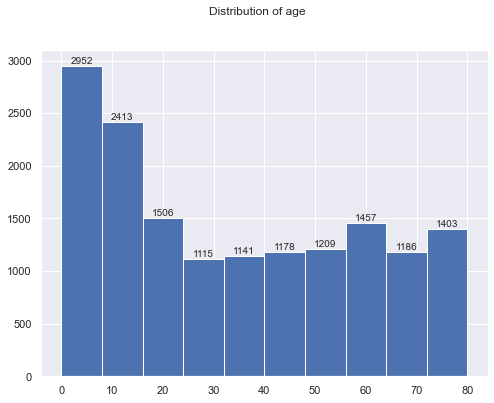

In [43]:
plt.figure(figsize=(8,6))
# Final_df.Age.hist()
freq, bins, patches = plt.hist(Final_df['Age'])
# x coordinate for labels
bin_centers = np.diff(bins)*0.5 + bins[:-1]

n = 0
for fr, x, patch in zip(freq, bin_centers, patches):
  height = int(freq[n])
  plt.annotate("{}".format(height),
               # top left corner of the histogram bar
               xy = (x, height),             
               # offsetting label position above its bar
               xytext = (0,0.2),             
               # Offset (in points) from the *xy* value
               textcoords = "offset points", 
               ha = 'center', va = 'bottom'
               )
  n = n+1

plt.suptitle("Distribution of age")

Highest number of participants belong to age group of 0-9 which is 2952 followed by 10-19 which is 2413, and then 20-29 which is 1506. We can conclude by looking at the above graph that most of the participants are young who participated in the survey.

In the above chart, ages from 0-10, 10-19, and so were clubbed together. Instead, we want to see distribution of individual ages.

Text(0.5, 0.98, 'Distribution of individual ages')

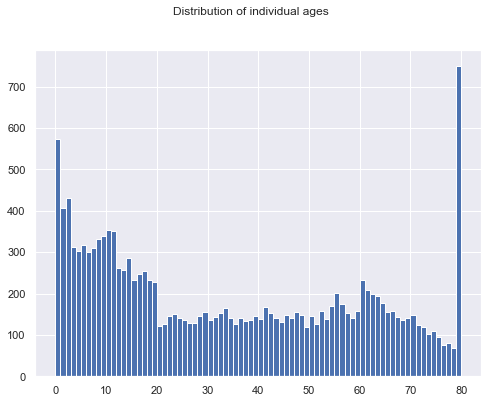

In [44]:
plt.figure(figsize=(8,6))
bins = np.arange(Final_df['Age'].min(), Final_df['Age'].max() + 1)
plt.hist(Final_df['Age'], bins=bins, density=False)
plt.suptitle("Distribution of individual ages")

For plotting the above chart, we are creating bins based on the min and max age in the dataset. Despite highest number of participants in age of 80 (which was not evident in the previous chart, we can clearly see the most of the participants were in the age range of 0-30 or even 0-40.

In [45]:
# sns.distplot(Final_df['Age'], bins=bins)
# sns.displot(Final_df['Age'], kde = True)

### 2. Distribution of age group (Dataset(s): Demographic)

Just like how we have plotted the distribution based on age, same way we have plotted the distribution based on age-group. Age-Group column was created from the RIDAGEYR column after the demographic data was read.

Text(0.5, 0.98, 'Distribution of age group')

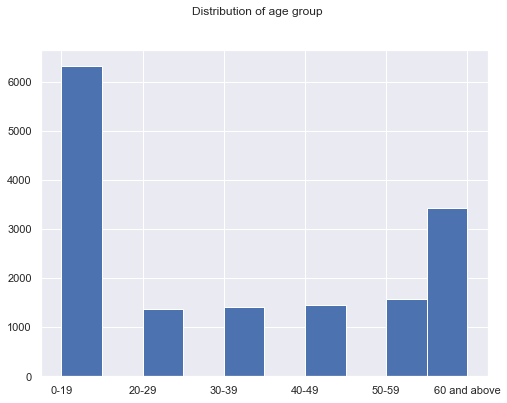

In [46]:
plt.figure(figsize=(8,6))
Final_df.Age_Group.sort_values().hist()
plt.suptitle("Distribution of age group")

Looking at above graph it is evident the most number of people who participated in the health survey's were from 0-19 age group. If we combine, 20-29 and 30-39 as well that is substantial number.

### 3. Distribution of Gender (Dataset(s): Demographic)

Next we are looking at the distrbution of male and female.

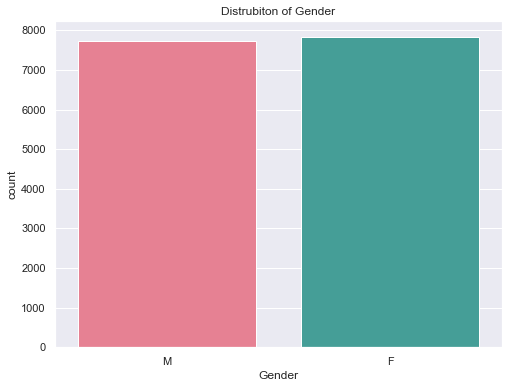

In [47]:
plt.figure(figsize=(8,6))
sns.countplot(x=Final_df['Gender'], label='Count', palette='husl')
plt.title("Distrubiton of Gender")
plt.show()

There is not much of a difference or gap between the two groups.

Next we want to further see the distribution of Age wrt Gender.

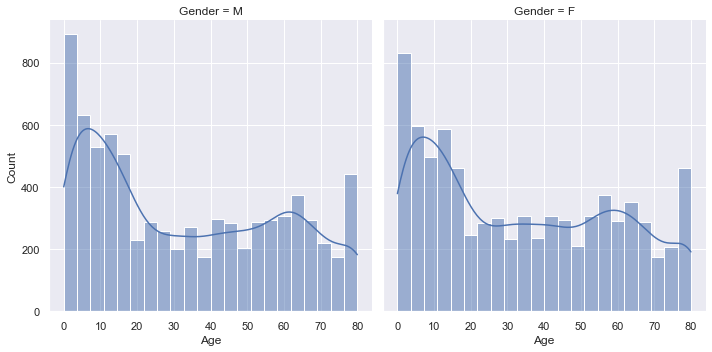

In [48]:
sns.displot(data=Final_df, x="Age", col="Gender", kde = True)

If we further break down or compare Age and Gender, again in both the groups, most of the participants were in age range of 0-30 or even 0-40, just like what we saw distribution wrt Age and Age Group.

### 4. Distribution of Marital Status (Dataset(s): Demographic)

Next we want to see the number of people participating in the survey based on Marital Status

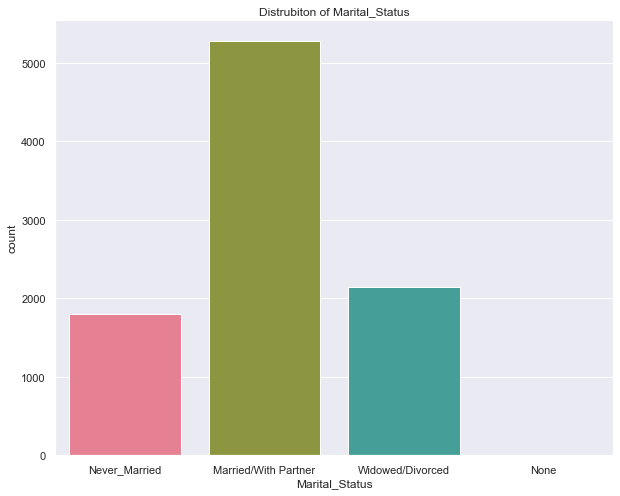

In [49]:
plt.figure(figsize=(10,8))
sns.countplot(x=Final_df['Marital_Status'], label='Count', \
              palette='husl')
plt.title("Distrubiton of Marital_Status")
plt.show()

Quite clearly, most number of participants are from Married/With Partner group. This category was created from DMDMARTZ column while read the demographic data.

### 5. Distribution of Height wrt Age (Dataset(s): Demographic, Body Measures)

Next, we want to check the height of the participants wrt Age

In [50]:
mean_height_by_age = Final_df.groupby('Age')['Standing Height (cm)']\
.mean()

Text(0, 0.5, 'Standing Height (cm)')

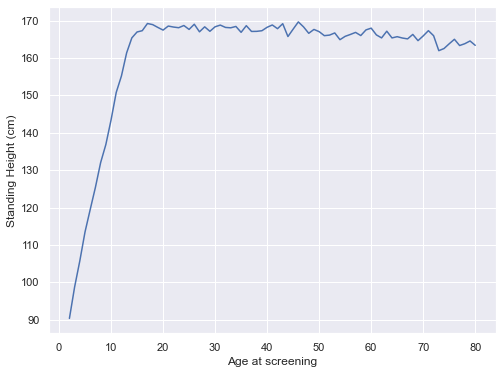

In [51]:
plt.figure(figsize=(8,6))
plt.plot(mean_height_by_age.index, mean_height_by_age)
plt.xlabel('Age at screening')
plt.ylabel('Standing Height (cm)')

As we can see above, the height of the participants increases from 0 till 17 or 18 and then becomes almost a plateau. It slightly starts decreasing from the age of 70 onwards.

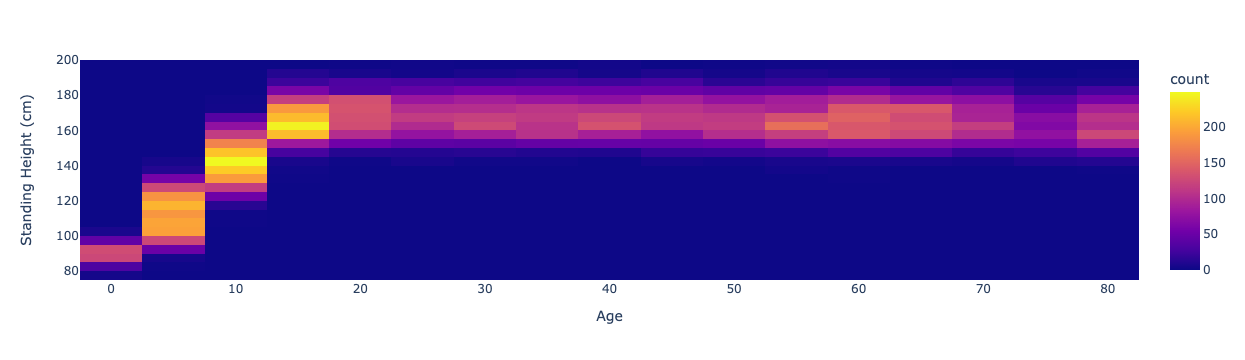

In [52]:
fig = px.density_heatmap(Final_df, x='Age', y='Standing Height (cm)')
fig.show()

We are looking an interactive plotly heatmap where you can mousehover to check the age group, and standing height range along with the count. The only thing not available is a filter for gender.

Next, we want to check the height of the participants wrt Age and further check it wrt to Gender.

Text(0.5, 0, 'Age at screening')

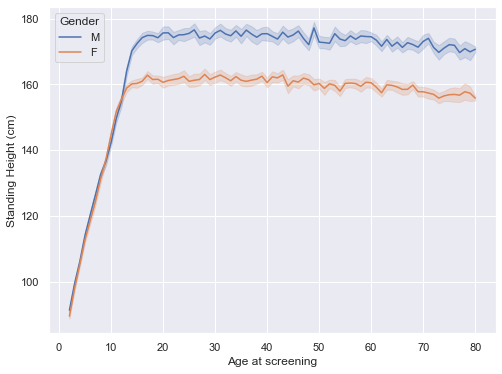

In [53]:
plt.figure(figsize=(8,6))
sns.lineplot(x='Age', y='Standing Height (cm)', hue='Gender',\
             data=Final_df)
plt.xlabel('Age at screening')

If compare the heights of female and male participants, we can see that heights of the female participants increases till the age of 12 and then becomes a plateau and then starts towards the end. If we see the male counter-parts, the height keeps increasing till the age of 16 or 17, becomes a plateau thereafter and again decreases towards the end.

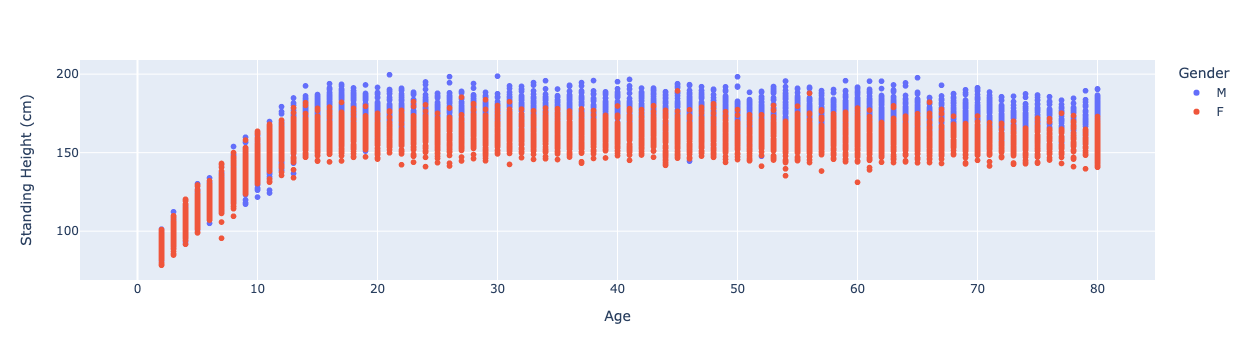

In [95]:
fig = px.scatter(Final_df, x='Age', y='Standing Height (cm)', \
                 color='Gender',size_max=20, hover_name='Gender')
fig.show()

Instead of a line graph, we have create a scatter plot and on mouse-hovering you can see the Gender, Age and Standing Height.

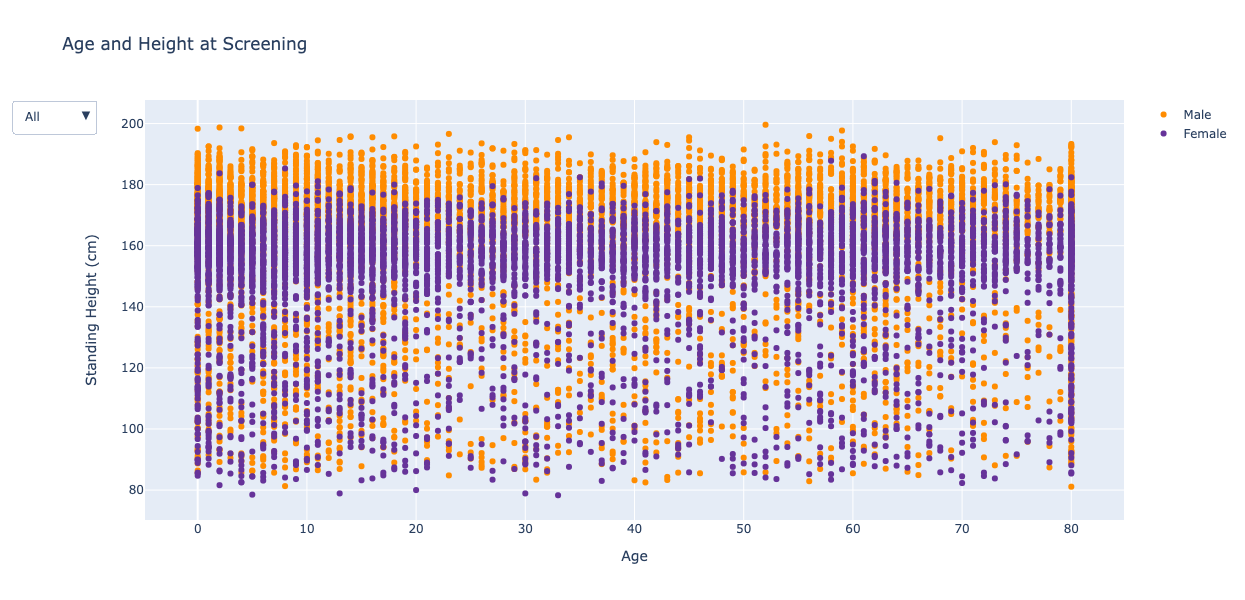

In [106]:
male = Final_df[Final_df['Gender'] == 'M']
female = Final_df[Final_df['Gender'] == 'F']
x = Final_df['Age']

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=male['Standing Height (cm)'],
                    mode='markers',
                    name='Male', marker=dict(color="DarkOrange"))),

fig.add_trace(go.Scatter(x=x, y=female['Standing Height (cm)'],
                    mode='markers', name='Female', \
                         marker=dict(color="RebeccaPurple")))

fig.update_layout(title_text='Age and Height at Screening',
                 xaxis_title='Age', yaxis_title='Standing Height (cm)')


fig.update_layout(
    updatemenus=[
        dict(active=0,
            buttons=list([
            dict(label="All",
                 method="update",
                 args=[{"visible":[True,True]},
                       {"title":"All"}]),
            dict(label="Male",
                 method="update",
                 args=[{"visible":[True, False]},
                       {"title":"Male"}]),
            dict(label="Female",
                 method="update",
                 args=[{"visible":[False,True]},
                       {"title":"Female"}]),
        ]),
        )
    ],
    width=900, height=600
)

fig.show()

The above is an interactive Age vs Standing Height graph where you can even select both the genders or only one of them.

Let's now look at the concentration of heights for both males and females using a box plot

<AxesSubplot:xlabel='Gender', ylabel='Standing Height (cm)'>

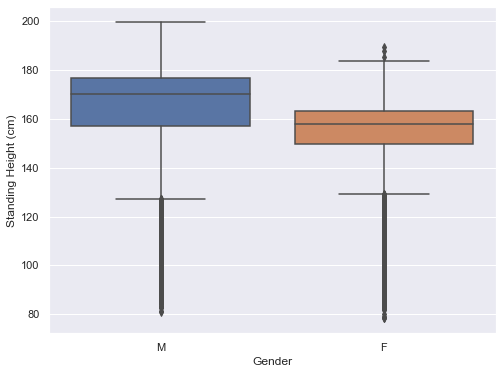

In [55]:
plt.figure(figsize=(8,6))
adult_nhanes_data = Final_df.query('Age > 0')
sns.boxplot(x='Gender', y='Standing Height (cm)', \
            data=adult_nhanes_data)

Looking at the above boxplot, we can see the most of the data for females is concentrated between 150 and 162 cms, whereas for males it is between 168 and 179 cms. There are quite a few outliers for both males and females for height below 130 cms wherease we don't see any outlier for males on the upper part.

Another way to look at the concentration of data is violin plot.

<AxesSubplot:xlabel='Gender', ylabel='Standing Height (cm)'>

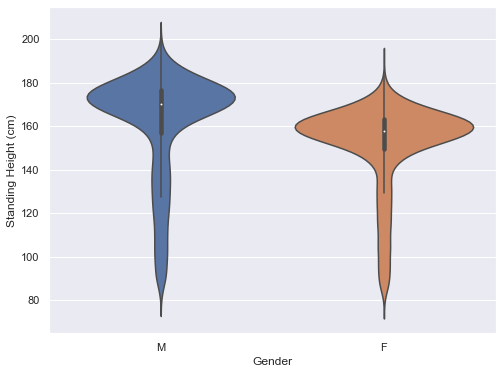

In [56]:
plt.figure(figsize=(8,6))
adult_nhanes_data = Final_df.query('Age > 0')
sns.violinplot(x='Gender', y='Standing Height (cm)', \
               data=adult_nhanes_data)

Largely the data is concentrated between 150 and 200 cms for males and between 140 and 180 for females.

### 6. Num of patients in Age, BMI, and Family_Income (Dataset(s): Demographic, Body Measures)

Next, we will plot Age, BMI and Family Income together in a separate sub-plots

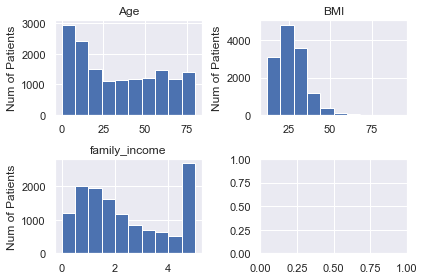

In [57]:
cols = ['Age','BMI','family_income']

fig, ax = plt.subplots(2, 2)
for i, col in enumerate(cols):
    ax[i//2, i%2].hist(Final_df[col])
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].set_ylabel("Num of Patients")
plt.tight_layout()

We have already seen the Age distribution above. 
If we look at BMI chart, there are too many people who are over-weight and obese even though most number of people have healthy weight.
If we look at Family_Income distribution, many people are in income group of 0-2. Here Family_income is ratio of income to ratio. Less the ratio, more likely you are less rich. Infact, highest number of people are in the high income to poverty ratio bracket.

We would now start by exploring the relationship between BMI and the gender of the person, to get an idea of how BMI varies among males and females.

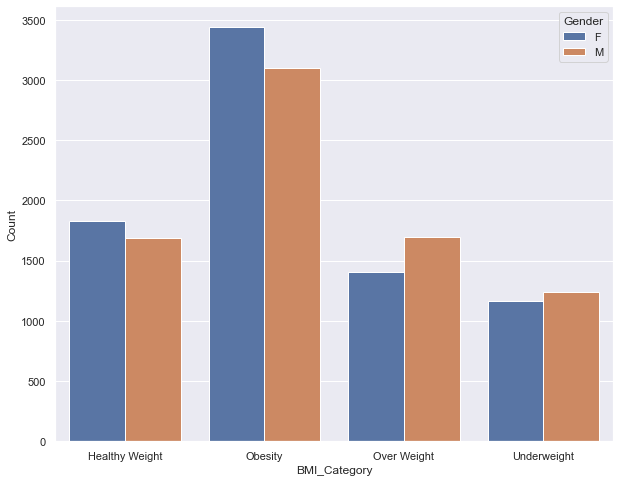

In [58]:
Gender_groupby = Final_df.groupby(['Gender','BMI_Category'], \
                                  as_index = False).count()
sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x="BMI_Category",y="HDL_Level",hue='Gender',\
            data=Gender_groupby)
plt.ylabel('Count')
plt.show()

As the above graph shows, although men are more likely to be overweight than women, women have higher chances of being obese.

One of our columns contains the HDL cholesterol level of the person. Normal HDL levels are above 40 according to CDC, so we would ideally use this information to categorize the person into two categories; ‘Normal’ and ‘Dangerzone’. We would add one more category called as Borderline. We will use HDL level and BMI category to divide the data into sections and examine how the BMI level affects the HDL level of a person.

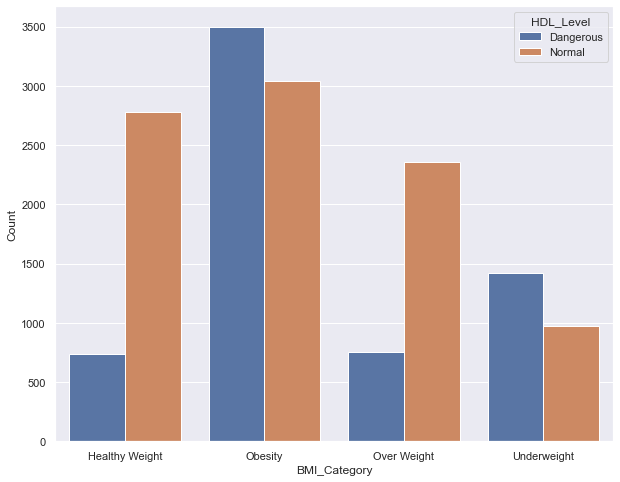

In [59]:
Gender_groupby = Final_df.groupby(['HDL_Level','BMI_Category'], \
                                  as_index = False).count()
sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x="BMI_Category",y="Gender",hue='HDL_Level',\
            data=Gender_groupby)
plt.ylabel('Count')
plt.show()

Being obese or overweight increases your chances of having dangerous HDL levels. Surprising if you are underweight, then too you may have dangerous HDL levels.

Similarly, we will use BMI levels to investigate their relationship with the diet taken by the person.

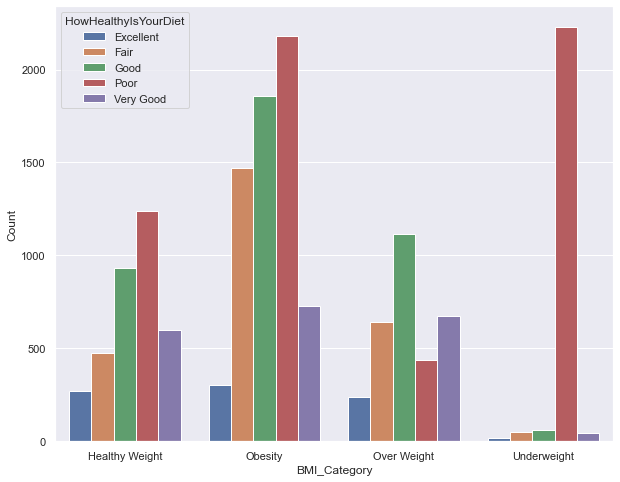

In [60]:
New_Diet_df = Final_df[['HowHealthyIsYourDiet','BMI_Category','HDL_Level']]
Diet_groupby = New_Diet_df.groupby(['HowHealthyIsYourDiet','BMI_Category'],\
                                   as_index = False).count()
sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x="BMI_Category",y="HDL_Level",hue='HowHealthyIsYourDiet',\
            data=Diet_groupby)
plt.ylabel('Count')
plt.show()

It is evident by looking into the above graph that the highest number of people having poor or fair diet end up facing obesity, while most of the people having excellent diet have a healthy weight.

### 7. Disease prevalance for all groups (Dataset(s): Medical Conditions, Diabetes)

Now, we will consider 4 major diseases from the dataset: Cancer, Diabetes, Coronary Heart Disease, and Liver Condition and see their prevalance in all thr groups.

In [61]:
Cancer_Subset = Final_df.dropna(subset=['Cancer']).copy()
Cancer_Subset.replace({7:None, 9:None, 77:None,99:None,777:None,\
                       999:None,7777:None,9999:None,77777:None,\
                       99999:None,777777:None,999999:None,55:None,\
                       555:None,5555:None,8:None,88:None}, inplace=True)
x = Cancer_Subset.nunique()
cat_cols = x[(x<15)].index
Cancer_Subset = trans_cat_cols(Cancer_Subset, cat_cols)
Cancer_Subset = filter_rows(Cancer_Subset)
Cancer_Subset = filter_columns(Cancer_Subset, cutoff = 0.9)
Cancer_Subset.fillna(Cancer_Subset.mode().iloc[0], inplace = True)
Cancer_Subset.shape

original number of rows:  9232
remaining rows:  9232
original number of columns:  288
number of columns removed:  12


(9232, 276)

In [62]:
Diabetes_Subset = Final_df.dropna(subset=['Diabetes']).copy()
Diabetes_Subset.replace({7:None, 9:None, 77:None,99:None,777:None,\
                       999:None,7777:None,9999:None,77777:None,\
                       99999:None,777777:None,999999:None,55:None,\
                       555:None,5555:None,8:None,88:None}, inplace=True)
x = Diabetes_Subset.nunique()
cat_cols = x[(x<15)].index
Diabetes_Subset = trans_cat_cols(Diabetes_Subset, cat_cols)
Diabetes_Subset = filter_rows(Diabetes_Subset)
Diabetes_Subset = filter_columns(Diabetes_Subset, cutoff = 0.9)
Diabetes_Subset.fillna(Diabetes_Subset.mode().iloc[0], inplace = True)
Diabetes_Subset.shape

original number of rows:  14986
remaining rows:  14986
original number of columns:  288
number of columns removed:  23


(14986, 265)

In [63]:
Coronary_Heart_Disease_Subset = Final_df.dropna(subset=['Coronary_Heart_Disease'])\
.copy()
Coronary_Heart_Disease_Subset.replace({7:None, 9:None, 77:None,99:None,777:None,\
                       999:None,7777:None,9999:None,77777:None,\
                       99999:None,777777:None,999999:None,55:None,\
                       555:None,5555:None,8:None,88:None}, inplace=True)
x = Coronary_Heart_Disease_Subset.nunique()
cat_cols = x[(x<15)].index
Coronary_Heart_Disease_Subset = trans_cat_cols(Coronary_Heart_Disease_Subset,\
                                               cat_cols)
Coronary_Heart_Disease_Subset = filter_rows(Coronary_Heart_Disease_Subset)
Coronary_Heart_Disease_Subset = filter_columns(Coronary_Heart_Disease_Subset,\
                                               cutoff = 0.5)
Coronary_Heart_Disease_Subset.fillna(Coronary_Heart_Disease_Subset.mode().iloc[0],\
                                     inplace = True)
Coronary_Heart_Disease_Subset.shape

original number of rows:  9232
remaining rows:  9232
original number of columns:  288
number of columns removed:  32


(9232, 256)

In [64]:
Liver_Condition_Subset = Final_df.dropna(subset=['Liver_Condition']).copy()
Liver_Condition_Subset.replace({7:None, 9:None, 77:None,99:None,777:None,\
                       999:None,7777:None,9999:None,77777:None,\
                       99999:None,777777:None,999999:None,55:None,\
                       555:None,5555:None,8:None,88:None}, inplace=True)
x = Liver_Condition_Subset.nunique()
cat_cols = x[(x<15)].index
Liver_Condition_Subset = trans_cat_cols(Liver_Condition_Subset, cat_cols)
Liver_Condition_Subset = filter_rows(Liver_Condition_Subset)
Liver_Condition_Subset = filter_columns(Liver_Condition_Subset, cutoff = 0.5)
Liver_Condition_Subset.fillna(Liver_Condition_Subset.mode().iloc[0], inplace = True)
Liver_Condition_Subset.shape

original number of rows:  462
remaining rows:  462
original number of columns:  288
number of columns removed:  21


(462, 267)

In [65]:
target_dfs = [Cancer_Subset,Diabetes_Subset,Coronary_Heart_Disease_Subset,\
              Liver_Condition_Subset]
targets = ['Cancer','Diabetes','Coronary_Heart_Disease','Liver_Condition']

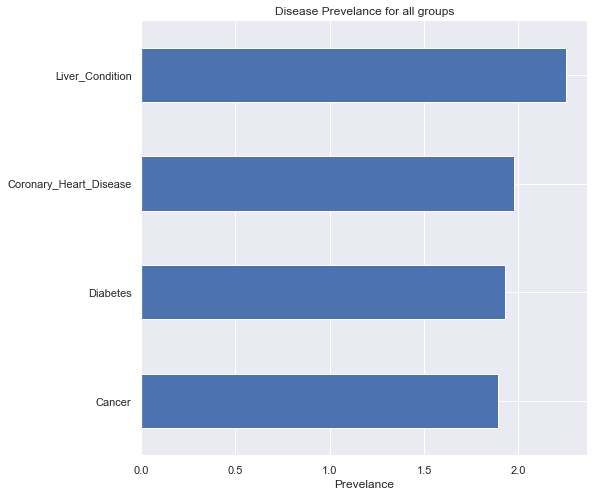

In [66]:
plot = Final_df[targets].mean(skipna=True).sort_values().plot.barh(figsize=(8,8))
plot.set_xlabel("Prevelance")
plot.set_title("Disease Prevelance for all groups")
plt.show()

As we can see, Liver Condition is the most prevalent amongst all groups whereas rest of the three diseases are almost same.

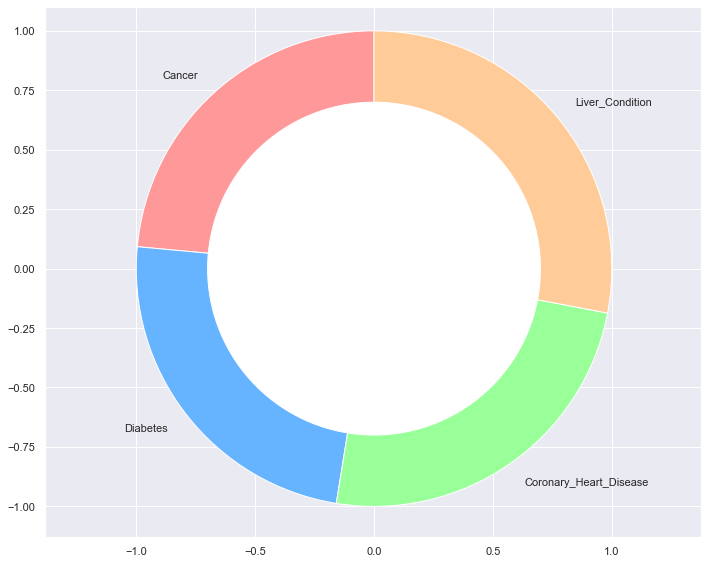

In [67]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
sizes = [Final_df[targets[0]].mean(skipna=True)\
         ,Final_df[targets[1]].mean(skipna=True)\
         ,Final_df[targets[2]].mean(skipna=True)\
         ,Final_df[targets[3]].mean(skipna=True)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=targets, startangle=90, frame=True)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Another representation of the 4 diseases using a pie chart. 

### 8. Diabetes Age Distribution (Dataset(s): Demographic, Diabetes)

We will now look at diabetes prevalance amongst various age groups.

<AxesSubplot:>

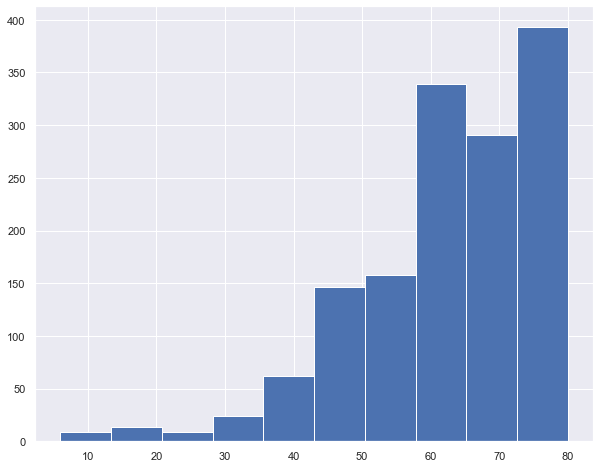

In [68]:
plt.figure(figsize=(10,8))
Diabetes_Subset[Diabetes_Subset['Diabetes']==1].Age.hist()

As we can see, diabetes becomes prevalent right after the age of 40. This can be assumed due to lack of vigorous physical activity which we will see shortly in the next chart. As the person grows older, due to absence of or less vigorous activity, he/she may develop diabetes which we can see right after the age of 59.

### 9. Age, Greatest Weight, Vigorous Activity comparison with respect to diabetes (Dataset(s): Demographic, Weight, Diabetes)

Next we will see what difference does vigorous physical activity makes on a person developing diabetes.

<Figure size 720x576 with 0 Axes>

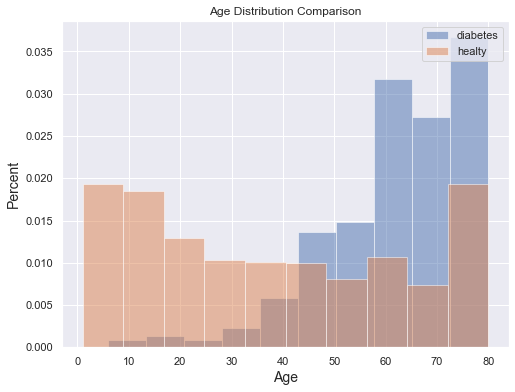

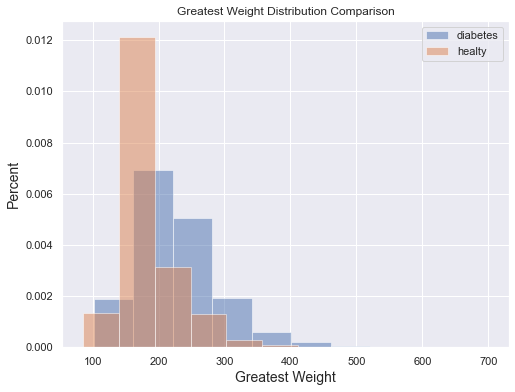

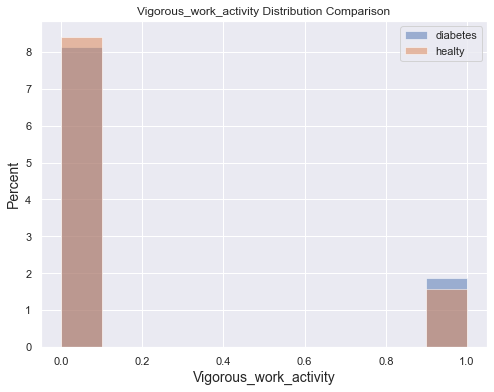

In [69]:
plt.figure(figsize=(10,8))
for col in ['Age','Greatest Weight','Vigorous_work_activity']:
    plt.figure(figsize=(8,6))
    plt.hist(Diabetes_Subset[Diabetes_Subset.Diabetes == 1][col], \
             bins=10, alpha=0.5, label="diabetes", density=True)
    plt.hist(Diabetes_Subset[Diabetes_Subset.Diabetes == 0][col], \
             bins=10, alpha=0.5, label="healty", density=True)
    plt.xlabel(col, size=14)
    plt.ylabel("Percent", size=14)
    plt.title(col + " Distribution Comparison")
    plt.legend(loc='upper right')
    plt.show()

1. In the first chart (Age vs Diabetes), it is straight forward that a person may develop diabetes as he/she grows older. 
2. In the 2nd chart where we are comparing greatest weight vs diabetes, person with heavier weight may get diabetes though in some cases, the person may not have diabetes despite having a heavier weight.
3. Lastly, not doing vigorous physical (or work) activity, person will develop diabetes. Even after doing vigorous physical activity you can develop diabetes but that number is low.

### 10. Age, Smoked at Work, and Job Duration distribution comparison with Cancer (Dataset(s): Demographic, Medical Conditions, Occupation)

<Figure size 720x576 with 0 Axes>

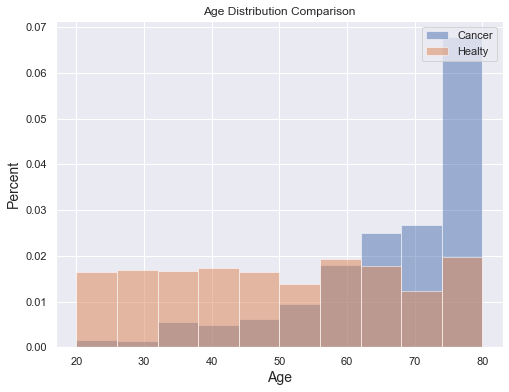

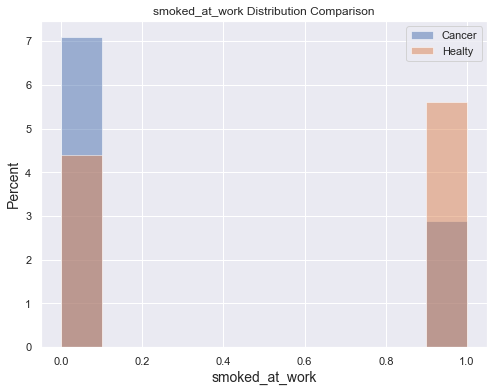

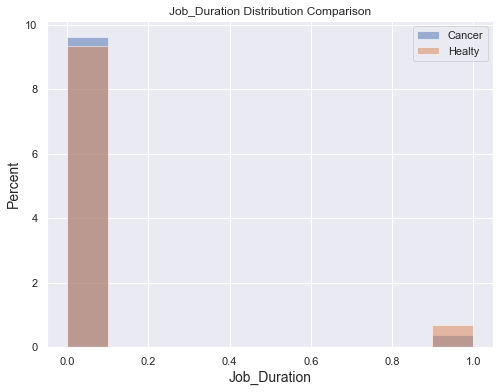

In [70]:
plt.figure(figsize=(10,8))
for col in ['Age','smoked_at_work','Job_Duration']:
    plt.figure(figsize=(8,6))
    plt.hist(Cancer_Subset[Cancer_Subset.Cancer == 1][col], \
             bins=10, alpha=0.5, label="Cancer", density=True)
    plt.hist(Cancer_Subset[Cancer_Subset.Cancer == 0][col], \
             bins=10, alpha=0.5, label="Healty", density=True)
    plt.xlabel(col, size=14)
    plt.ylabel("Percent", size=14)
    plt.title(col + " Distribution Comparison")
    plt.legend(loc='upper right')
    plt.show()

1. Just like diabetes, a person may get cancer after the age of 29.
2. Next, a person will get cancer if he/she smoked at work.
3. Lastly, if a person doesn't works for more than 35 hours a week, he will get cancer. 

### 10. Diastolic and Systolic Blood Pressure (Dataset(s): Blood Pressure)

Text(0, 0.5, 'Systolic BP - Second reading')

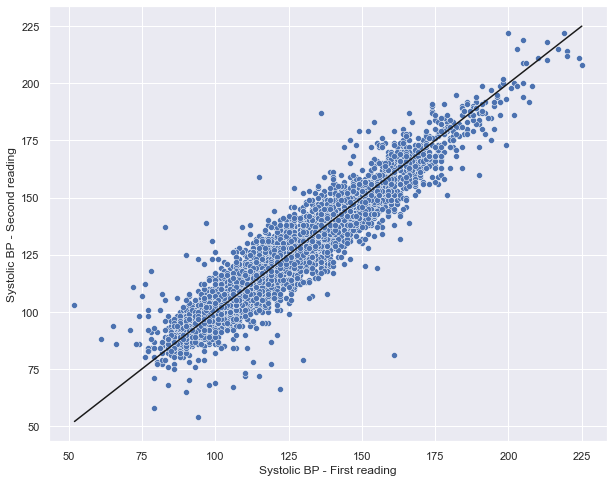

In [71]:
sns.scatterplot(x='SBPReading1',
                y='SBPReading2',
                data=Final_df)
plt.plot([Final_df['SBPReading1'].min(),
          Final_df['SBPReading1'].max()],
          [Final_df['SBPReading1'].min(),
          Final_df['SBPReading1'].max()],
          color='k')
plt.xlabel('Systolic BP - First reading')
plt.ylabel('Systolic BP - Second reading')

The above scatter plot shows the relationship between the first 2 readings of Systolic Blood Pressure. There are few outliers but largely most of the data points are closer to the regression line. Since we are measuring the same variable 3 times (for this analysis we are comparing the first 2 readings), so mostly both the readings are almost similar (or same) and thus in some sense it depicts that the measurement is accurate and shows a strong relationship.

We will now plot diastolic and systolic distribution together. For this we have taken average of diastolic variables and calculated another variable called as Systolic_BP and same way for systolic blood pressures we have created another variable called as Systolic_BP.

In [72]:
#All the data with no age or gender filter.
sys_t = np.array(Final_df.Systolic_BP)
dia_t = np.array(Final_df.Diastolic_BP)
sys_mean = np.mean(Final_df[['Systolic_BP']].mean(numeric_only=True))
dia_mean = np.mean(Final_df[['Diastolic_BP']].mean(numeric_only=True))
sys_median = np.mean(Final_df[['Systolic_BP']].median(numeric_only=True))
dia_median = np.mean(Final_df[['Diastolic_BP']].median(numeric_only=True))
sys_std = np.mean(Final_df[['Systolic_BP']].std(numeric_only=True))
dia_std = np.mean(Final_df[['Diastolic_BP']].std(numeric_only=True))

/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



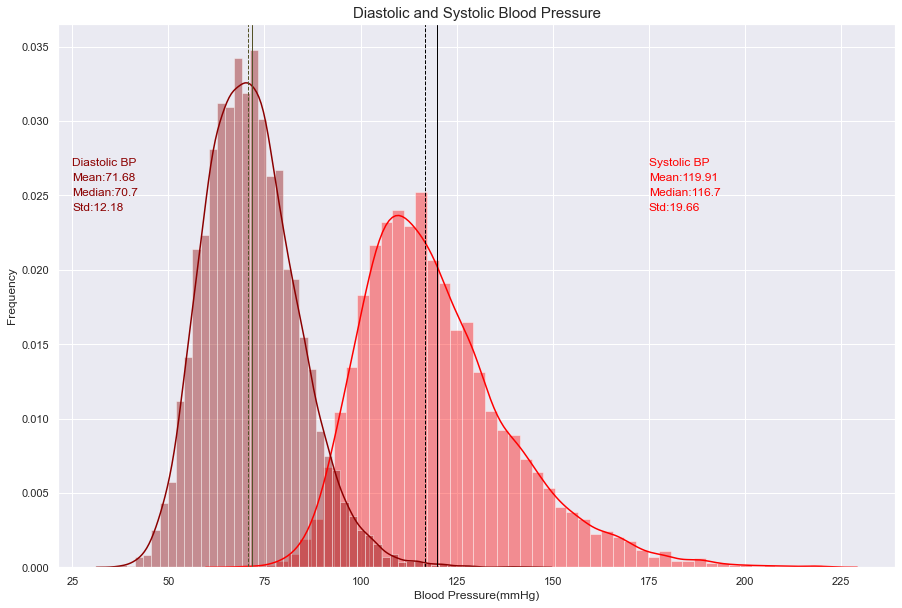

In [73]:
#Plotting graph
plt1.figure(figsize=(15,10))
sns.distplot(sys_t, color = '#FF0000')
sns.distplot(dia_t, color = '#8B0000')
plt1.axvline(sys_mean, ls = '-', lw = 1, color = '#000000')
plt1.axvline(dia_mean, ls = '-', lw = 1, color = '#545328')
plt1.axvline(sys_median, ls = '--', lw = 1, color = '#000000')
plt1.axvline(dia_median, ls = '--', lw = 1, color = '#545328')
plt1.xlabel('Blood Pressure(mmHg)')
plt1.ylabel('Frequency')
plt1.title(('Diastolic and Systolic Blood Pressure'), fontsize= 15)
plt1.text(175, 0.027, 'Systolic BP', color = '#FF0000')
plt1.text(175, 0.026, ('Mean:' + str(round(sys_mean, 2))), color = '#FF0000')
plt1.text(175, 0.025, ('Median:' + str(sys_median)), color = '#FF0000')
plt1.text(175, 0.024, ('Std:' + str(round(sys_std, 2))), color = '#FF0000')

plt1.text(25, 0.027, 'Diastolic BP', color = '#8B0000')
plt1.text(25, 0.026, ('Mean:' + str(round(dia_mean, 2))), color = '#8B0000')
plt1.text(25, 0.025, ('Median:'+ str(dia_median)), color = '#8B0000')
plt1.text(25, 0.024, ('Std:'+ str(round(dia_std, 2))), color = '#8B0000')


plt1.show()

Overall, lower blood pressure represents the diastole phase once there is ventricular relaxation and systole phase is marked by ventricular contraction, which increases the blood pressure over arteries. Above we have created a simple distribution chart showing KDE and histogram of diastolic and systolic BP from all groups. The mean diastolic BP is 71.68 mmHg and the mean systolic BP is 119.91 mmHg represented by a solid vertical line, and the median as a dashed vertical line. The diastolic chart partly looks normally distributed (since median and mean values are very close to each other) but actually it is marginally right skewed whereas systolic part is right skewed (as there is some difference between median and mean values and obviously mean is on the right side of the median). The right skewness can be attributed to the fact that more people are now having high blood pressure which could because of several factors.

#### 11. Summarizing Smoking Data (Dataset(s): Smoking - Cigarette Use)

We will now compare people who have smoked atleast 100 cigarettes in their lives vs people who smoke now or not.

In [74]:
smoking_df = Final_df[['SmokedAtLeast100CigarettesInLife', \
                       'DoYouNowSmokeCigarettes']].copy()
smoking_df.replace({7:None, 9:None, 77:None,99:None,777:None,\
                       999:None,7777:None,9999:None,77777:None,\
                       99999:None,777777:None,999999:None,55:None,\
                       555:None,5555:None,8:None,88:None}, inplace=True)
smoking_df.shape

(15560, 2)

In [75]:
smoking_df = smoking_df.dropna(how='all') # dropping rows if both the columns are null or NA
smoking_df.shape

(9688, 2)

In [76]:
print(smoking_df['SmokedAtLeast100CigarettesInLife'].value_counts())

2.0    5799
1.0    3889
Name: SmokedAtLeast100CigarettesInLife, dtype: int64


#### 1 above means, sample population has smoke atleast 100 cigarettes in life where 2 means they have not

In [77]:
print(smoking_df['DoYouNowSmokeCigarettes'].value_counts())

3.0    2205
1.0    1306
2.0    378 
Name: DoYouNowSmokeCigarettes, dtype: int64


In [78]:
smoking_df.loc[smoking_df['SmokedAtLeast100CigarettesInLife'] == 2,\
               'DoYouNowSmokeCigarettes'] = 'Not at all'
smoking_df.loc[smoking_df['DoYouNowSmokeCigarettes'] == 1,\
               'DoYouNowSmokeCigarettes'] = 'Every day'
smoking_df.loc[smoking_df['DoYouNowSmokeCigarettes'] == 2,\
               'DoYouNowSmokeCigarettes'] = 'Some days'
smoking_df.loc[smoking_df['DoYouNowSmokeCigarettes'] == 3,\
               'DoYouNowSmokeCigarettes'] = 'Not at all'
smoking_df.head(5)

SmokedAtLeast100CigarettesInLife DoYouNowSmokeCigarettes
3   2.0                              Not at all            
4   2.0                              Not at all            
5   2.0                              Not at all            
8   1.0                              Every day             
10  1.0                              Every day

In [79]:
smoking_df['DoYouNowSmokeCigarettes'].value_counts() / \
smoking_df['DoYouNowSmokeCigarettes'].value_counts().sum() * 100

Not at all    82.617671
Every day     13.480595
Some days     3.901734 
Name: DoYouNowSmokeCigarettes, dtype: float64

82.6% of the sample population do not smoke at all whereas 13.4% smoke every day and 3.9% smoke some days. It is really good that majority of the population is a non-smoker.

# SUMMARY

In this task, I have covered 12 datasets from 4 different components:<br>
a. Demographic,<br> b. Questionnaire,<br> c. Examination, and<br>d. Laboratory.<br><br> Prior to visualization, data following data wrangling techniques have been applied such as column transformation, missing value handling, filtering etc. Post that 8 different chart types and one non-chart based summarization has been provided. The above analysis is a mix of several things starting with simple distribution like Age, Age Group, Gender, Marital Status, Height wrt Age, and so on. In this exercise, I have covered relationship of Age, Weight, and Vigorous activity wrt Diabetes and same way Age and Smoked at Work with Cancer. There are several simple distributions (with one variable), and few not-so-simple distributions (with 2 or more variables). I have also added <b>Plotly</b> charts in Age vs Standing Height comparison. In one of the charts you can even filter the data points based on Gender.

In my opinion, there are largely no data privacy issues because no personally identifiable information (PII) has been shared such as Name, Location, Date of Birth etc has been put in the demographic details. Despite Place of birth, ethinicity, educational and medical information available, they on their own do not constitute PII as same can be shared by more than one person. Some sensitive data which is part of Limited Access Data component is not publicly available and can only be accesses after sending a request to Research Data Center (RDC), so ethically also care has been taken to restrict it's access. 

To conclude, there is much more one can do with this amount of data. There are so many important and key datasets one could explore and additionally we can also build some ML models for disease prediction(s).

#### End of assignment